# Find Offensive players depending on their historical shot selection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

In [26]:
df2020 = pd.read_csv('../Data/shot_chart_2020-21.csv')
df2021 = pd.read_csv('../Data/shot_chart_2021-22.csv')

In [27]:
df2020[['EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'HTM', 'VTM']]

,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,HTM,VTM
0,Made Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,CHI,ATL
1,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,CHI,ATL
2,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,CHI,ATL
3,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,CHI,ATL
4,Missed Shot,Running Jump Shot,3PT Field Goal,Above the Break 3,Back Court(BC),Back Court Shot,40,MEM,ATL
...,...,...,...,...,...,...,...,...,...
176350,Made Shot,Cutting Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,WAS,CHA
176351,Missed Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,WAS,CHA
176352,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,WAS,CHA
176353,Missed Shot,Driving Layup Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,WAS,CHA


In [28]:
drop_cols = ['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID','TEAM_ID', 'TEAM_NAME','GAME_DATE','SHOT_ATTEMPTED_FLAG', 'EVENT_TYPE', 'SHOT_TYPE']

In [29]:
player_counts = df2020.groupby('PLAYER_ID').size()
relevant_players = player_counts.where(player_counts > 100).dropna()

In [30]:
shot_selection = (df2020[df2020.PLAYER_ID.isin(relevant_players.index)].groupby(['PLAYER_ID', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).size()/df2020.groupby('PLAYER_ID').size()).rename('Percentage').reset_index()
shot_selection['shot_zone'] = shot_selection.apply(lambda x: f'{x.SHOT_ZONE_AREA}, {x.SHOT_ZONE_BASIC}', axis = 1)
shot_selection = shot_selection.drop(['SHOT_ZONE_BASIC','SHOT_ZONE_AREA'], axis = 1)

shot_selection = shot_selection.pivot(index='PLAYER_ID', 
                                      columns='shot_zone', 
                                      values='Percentage').fillna(0)

shot_selection

shot_zone,"Back Court(BC), Above the Break 3","Back Court(BC), Backcourt","Center(C), Above the Break 3","Center(C), In The Paint (Non-RA)","Center(C), Mid-Range","Center(C), Restricted Area","Left Side Center(LC), Above the Break 3","Left Side Center(LC), Mid-Range","Left Side(L), In The Paint (Non-RA)","Left Side(L), Left Corner 3","Left Side(L), Mid-Range","Right Side Center(RC), Above the Break 3","Right Side Center(RC), Mid-Range","Right Side(R), In The Paint (Non-RA)","Right Side(R), Mid-Range","Right Side(R), Right Corner 3"
PLAYER_ID,,,,,,,,,,,,,,,,
2544,0.000000,0.000000,0.104496,0.103281,0.030377,0.348724,0.126367,0.027947,0.010936,0.015796,0.053463,0.088700,0.021871,0.007290,0.049818,0.010936
2546,0.000000,0.000000,0.045045,0.057915,0.028314,0.074646,0.146718,0.037323,0.015444,0.045045,0.111969,0.135135,0.052767,0.012870,0.190476,0.046332
2730,0.000000,0.003300,0.033003,0.141914,0.013201,0.739274,0.009901,0.013201,0.000000,0.003300,0.009901,0.009901,0.000000,0.006601,0.009901,0.006601
2738,0.000000,0.020161,0.028226,0.052419,0.004032,0.161290,0.181452,0.012097,0.004032,0.165323,0.004032,0.133065,0.016129,0.000000,0.012097,0.205645
2772,0.000000,0.004149,0.049793,0.049793,0.008299,0.331950,0.178423,0.004149,0.008299,0.103734,0.000000,0.095436,0.004149,0.000000,0.000000,0.161826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630237,0.000000,0.000000,0.076271,0.050847,0.000000,0.330508,0.186441,0.000000,0.000000,0.067797,0.008475,0.186441,0.000000,0.016949,0.000000,0.076271
1630240,0.004762,0.000000,0.014286,0.314286,0.014286,0.514286,0.033333,0.004762,0.014286,0.028571,0.009524,0.019048,0.009524,0.004762,0.004762,0.009524
1630256,0.001600,0.000000,0.028800,0.168000,0.001600,0.492800,0.073600,0.003200,0.009600,0.072000,0.003200,0.073600,0.004800,0.001600,0.003200,0.062400


In [31]:
scale = StandardScaler()

scaled_shot_selection = pd.DataFrame(data = scale.fit_transform(shot_selection),
                              columns = shot_selection.columns,
                                     index = shot_selection.index)

# import umap

# reducer = umap.UMAP()

# embedding = reducer.fit_transform(scaled_shot_selection)
# embedding.shape

# import matplotlib.pyplot as plt
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],)
#     # c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the shot selection dataset', fontsize=24)

In [32]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = scaled_shot_selection.values
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

# Find optimal K

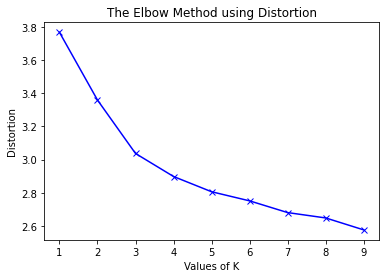

In [33]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

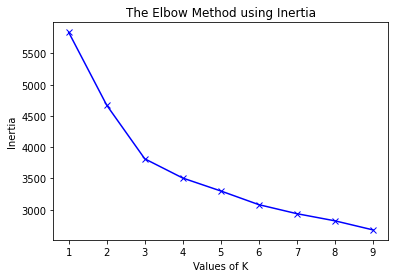

In [34]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# After Optimal K is found, analyse the clusters

In [35]:
model = KMeans(n_clusters=7, random_state=42).fit(scaled_shot_selection)

scaled_shot_selection['clusters'] = model.labels_

In [36]:
player_map = dict(df2020.groupby(['PLAYER_ID', 'PLAYER_NAME']).size().index)

scaled_shot_selection = scaled_shot_selection.reset_index()

scaled_shot_selection['PLAYER'] = scaled_shot_selection['PLAYER_ID'].replace(player_map)

# investigate shot charts of different clusters

In [37]:
player_cluster_map = dict(zip(scaled_shot_selection.PLAYER_ID,
         scaled_shot_selection.clusters))

In [38]:
scaled_shot_selection

shot_zone,PLAYER_ID,"Back Court(BC), Above the Break 3","Back Court(BC), Backcourt","Center(C), Above the Break 3","Center(C), In The Paint (Non-RA)","Center(C), Mid-Range","Center(C), Restricted Area","Left Side Center(LC), Above the Break 3","Left Side Center(LC), Mid-Range","Left Side(L), In The Paint (Non-RA)","Left Side(L), Left Corner 3","Left Side(L), Mid-Range","Right Side Center(RC), Above the Break 3","Right Side Center(RC), Mid-Range","Right Side(R), In The Paint (Non-RA)","Right Side(R), Mid-Range","Right Side(R), Right Corner 3",clusters,PLAYER
0,2544,-0.222523,-0.600994,0.726293,-0.644248,0.174876,0.158792,0.186251,0.971123,0.276132,-0.903914,1.249746,-0.284808,0.402656,-0.272916,1.004018,-0.926175,1,LeBron James
1,2546,-0.222523,-0.600994,-0.576615,-1.240576,0.079787,-1.364961,0.489176,1.669014,0.875962,-0.215034,3.929345,0.419677,2.488310,0.423074,7.086020,-0.091880,1,Carmelo Anthony
2,2730,-0.222523,0.521510,-0.840519,-0.136412,-0.616916,2.330075,-1.547330,-0.126361,-1.178817,-1.198210,-0.745403,-1.480293,-1.073781,-0.358953,-0.721963,-1.028349,0,Dwight Howard
3,2738,-0.222523,6.256235,-0.945221,-1.312817,-1.039614,-0.883257,1.006180,-0.208572,-0.642337,2.617754,-1.014193,0.388263,0.015025,-1.182308,-0.627018,3.663130,5,Andre Iguodala
4,2772,-0.222523,0.810286,-0.472570,-1.347346,-0.842926,0.065536,0.961103,-0.800095,-0.074693,1.167224,-1.198871,-0.182617,-0.793673,-1.182308,-1.150077,2.630306,5,Trevor Ariza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1630237,-0.222523,-0.600994,0.107730,-1.333479,-1.225503,0.057521,1.080441,-1.108932,-1.178817,0.320813,-0.810733,1.198051,-1.073781,0.931899,-1.150077,0.613785,4,Anthony Lamb
361,1630240,5.353058,-0.600994,-1.250729,2.129401,-0.566925,1.079241,-1.198543,-0.754505,0.721854,-0.603023,-0.762678,-1.341526,-0.430867,-0.588316,-0.944175,-0.959451,0,Saben Lee
362,1630256,1.650872,-0.600994,-0.932637,0.206484,-1.151742,0.959789,-0.599178,-0.870757,0.098434,0.419811,-1.052310,-0.513893,-0.749752,-0.982727,-1.011711,0.286841,4,Jae'Sean Tate
363,1630267,3.494531,1.558489,1.427864,-0.624777,-1.079152,-0.915140,0.431706,-1.108932,0.088297,1.041886,-0.908076,1.451927,-0.216562,-0.786314,-0.326467,1.060835,2,Facundo Campazzo


In [110]:
df2020['cluster'] = df2020['PLAYER_ID'].replace(player_cluster_map)
cluster_df = df2020.merge(scaled_shot_selection, on ='PLAYER_ID')

In [111]:


def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [112]:
def investigate_shot_chart(cluster, data=cluster_df):
    
    np.random.seed(42)
    
    
    cluster = data.query(f'cluster == {cluster}')
    player_ids = np.random.choice(cluster['PLAYER_ID'].unique(), [1])
    cluster = cluster[cluster.PLAYER_ID.isin(player_ids)]
    
    plt.figure(figsize=(12,11))
    draw_court(outer_lines=True)
    plt.scatter(cluster.LOC_X, cluster.LOC_Y, marker = 'X', c='red')
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.show()

In [113]:
for i in range(7):
    print(i)
    print(df2020.query(f'cluster == {i}')['PLAYER_NAME'].unique())
    print('-'*100)

0
['Clint Capela' 'Onyeka Okongwu' 'Tristan Thompson' 'Robert Williams III'
 'Jarrett Allen' 'Zion Williamson' 'Willy Hernangomez' 'Jaxson Hayes'
 'Steven Adams' 'Thaddeus Young' 'Dwight Powell' 'Willie Cauley-Stein'
 'Kevon Looney' 'Ivica Zubac' 'Andre Drummond' 'Montrezl Harrell'
 'Precious Achiuwa' 'Jarred Vanderbilt' 'Bruce Brown' 'DeAndre Jordan'
 'Nic Claxton' 'Nerlens Noel' 'Elfrid Payton' 'Mitchell Robinson'
 'Taj Gibson' 'Domantas Sabonis' 'JaKarr Sampson' 'Ben Simmons'
 'Dwight Howard' 'Deandre Ayton' 'Enes Freedom' 'Jusuf Nurkic'
 'Hassan Whiteside' 'Marvin Bagley III' 'Drew Eubanks' 'Jakob Poeltl'
 'Tony Bradley' "DeAndre' Bembry" 'Derrick Favors' 'Rudy Gobert'
 'Jonas Valanciunas' 'Robin Lopez' 'Daniel Gafford' 'Alex Len'
 'Jahlil Okafor' 'Mason Plumlee' 'Isaiah Stewart' 'Saben Lee'
 'Bismack Biyombo' 'Cody Zeller']
----------------------------------------------------------------------------------------------------
1
['Lou Williams' 'Danilo Gallinari' "De'Andre Hunter" 'Ja

0


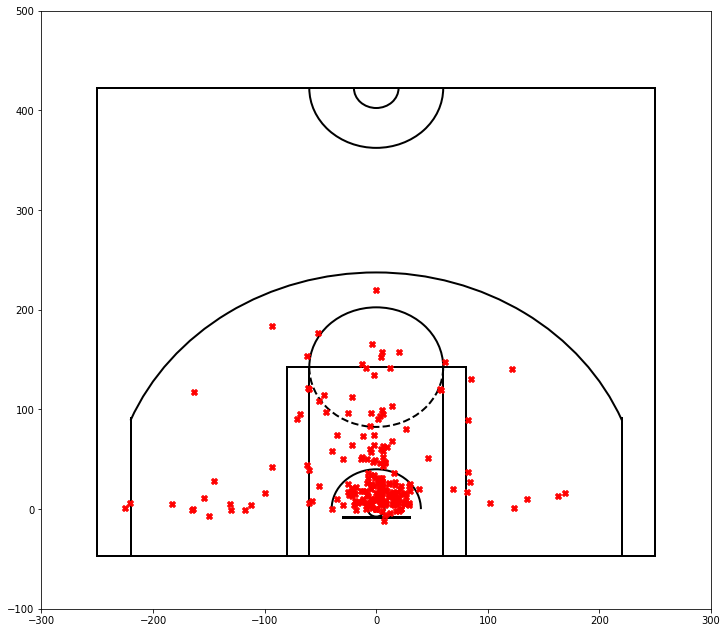

1


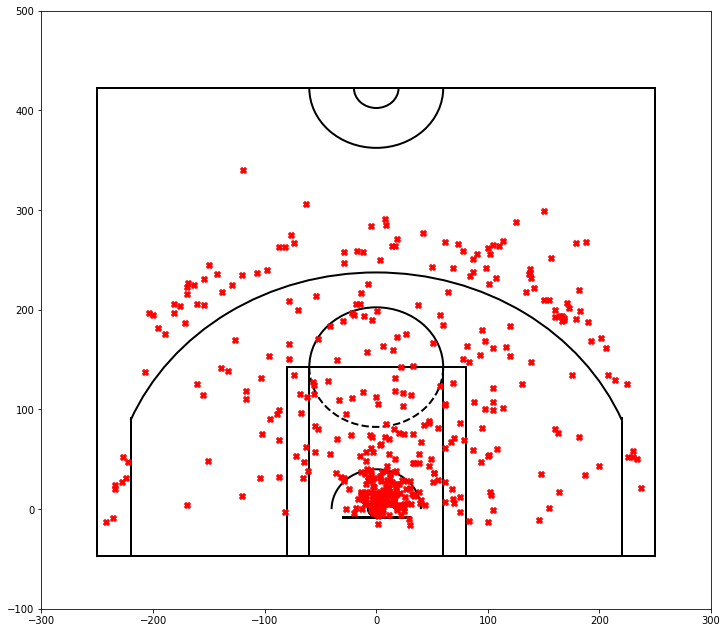

2


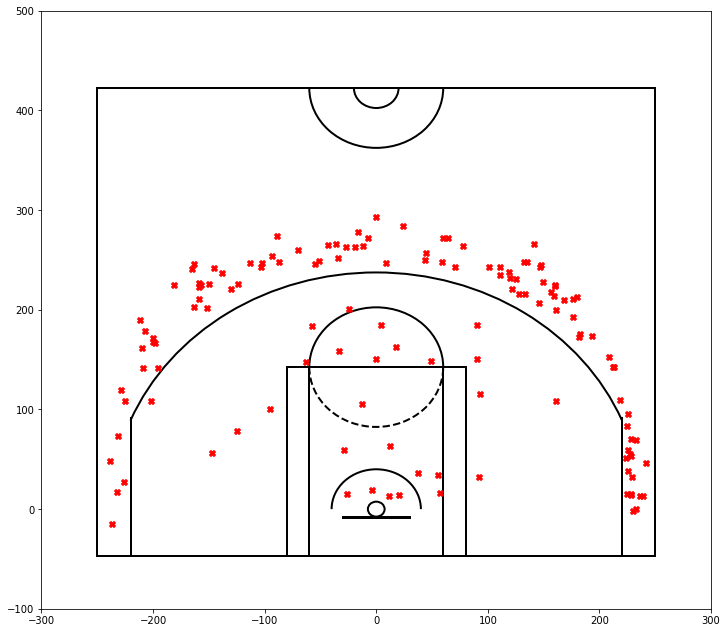

3


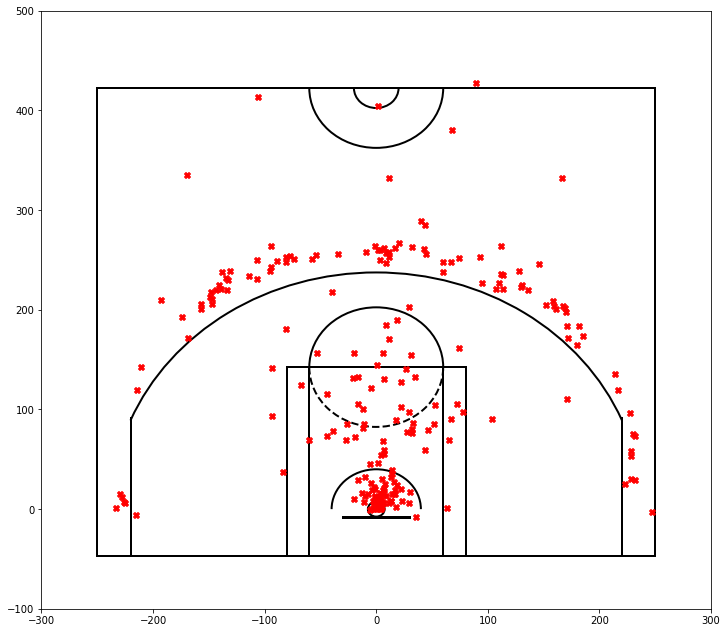

4


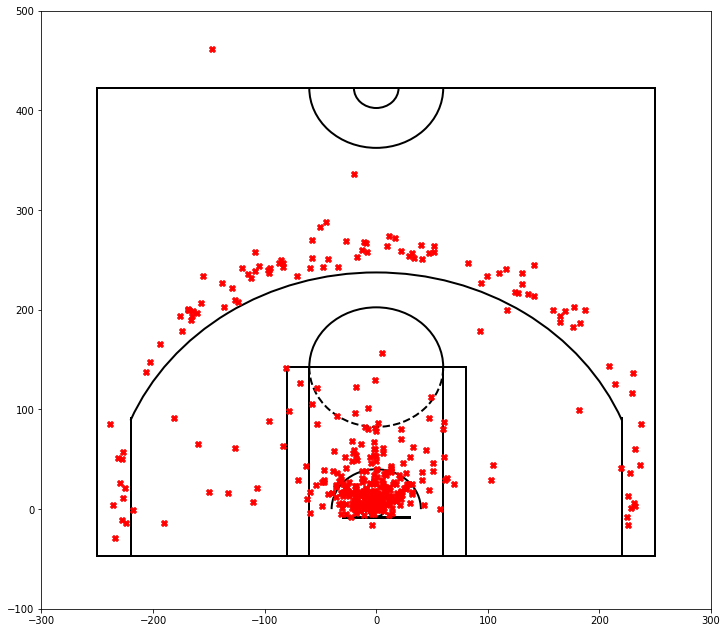

5


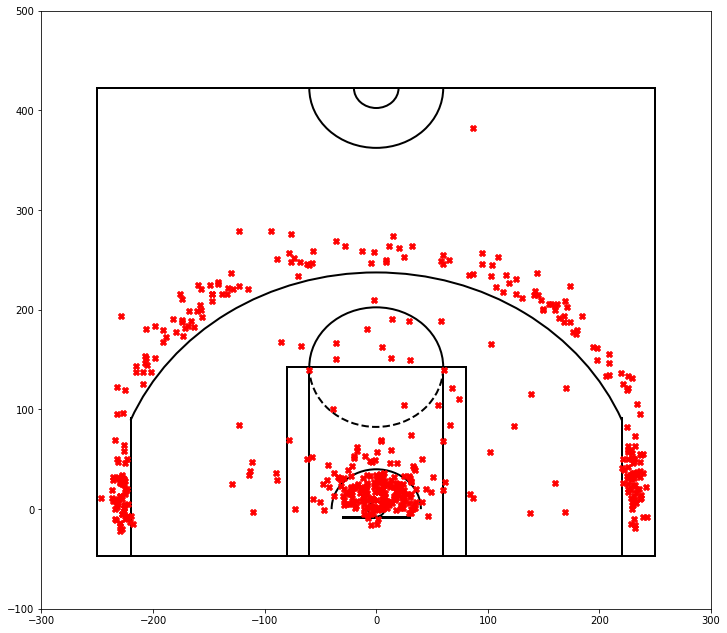

6


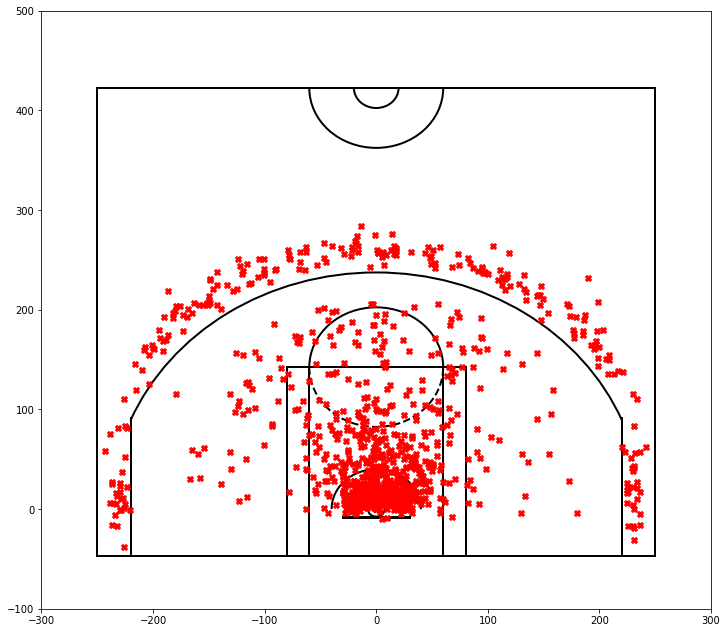

In [114]:
for i in range(7):
    print(i)
    investigate_shot_chart(i)

In [115]:
cluster_df.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM', 'cluster', 'Back Court(BC), Above the Break 3',
       'Back Court(BC), Backcourt', 'Center(C), Above the Break 3',
       'Center(C), In The Paint (Non-RA)', 'Center(C), Mid-Range',
       'Center(C), Restricted Area', 'Left Side Center(LC), Above the Break 3',
       'Left Side Center(LC), Mid-Range',
       'Left Side(L), In The Paint (Non-RA)', 'Left Side(L), Left Corner 3',
       'Left Side(L), Mid-Range', 'Right Side Center(RC), Above the Break 3',
       'Right Side Center(RC), Mid-Range',
       'Right Side(R), In The Paint (Non-RA)', 'Right Side(R), Mid-Range',
       'Right Side(R), Right Corne

In [116]:
import sqlite3
import pandas as pd

connection = sqlite3.connect("../Data/basketball.sqlite")

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", connection)

tables

def read_data(table, con=connection):
    return pd.read_sql(f"""SELECT * FROM {table}""", con)

active_players = read_data('Player').query('is_active==1')

In [118]:
cluster_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,"Left Side(L), In The Paint (Non-RA)","Left Side(L), Left Corner 3","Left Side(L), Mid-Range","Right Side Center(RC), Above the Break 3","Right Side Center(RC), Mid-Range","Right Side(R), In The Paint (Non-RA)","Right Side(R), Mid-Range","Right Side(R), Right Corner 3",clusters,PLAYER
0,Shot Chart Detail,22000015,477,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,5,11,...,0.014429,-0.747866,-0.582724,0.342451,-0.771064,2.173877,-0.762279,-0.338366,3,Brandon Goodwin
1,Shot Chart Detail,22000015,497,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,3,29,...,0.014429,-0.747866,-0.582724,0.342451,-0.771064,2.173877,-0.762279,-0.338366,3,Brandon Goodwin
2,Shot Chart Detail,22000015,530,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,0,47,...,0.014429,-0.747866,-0.582724,0.342451,-0.771064,2.173877,-0.762279,-0.338366,3,Brandon Goodwin
3,Shot Chart Detail,22000015,673,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,4,3,20,...,0.014429,-0.747866,-0.582724,0.342451,-0.771064,2.173877,-0.762279,-0.338366,3,Brandon Goodwin
4,Shot Chart Detail,22000021,159,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,1,0,0,...,0.014429,-0.747866,-0.582724,0.342451,-0.771064,2.173877,-0.762279,-0.338366,3,Brandon Goodwin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170181,Shot Chart Detail,22001080,153,203469,Cody Zeller,1610612766,Charlotte Hornets,1,1,47,...,-1.178817,-1.130556,-1.057512,-1.349553,-0.448726,-0.027325,-1.150077,-0.965686,0,Cody Zeller
170182,Shot Chart Detail,22001080,177,203469,Cody Zeller,1610612766,Charlotte Hornets,1,0,0,...,-1.178817,-1.130556,-1.057512,-1.349553,-0.448726,-0.027325,-1.150077,-0.965686,0,Cody Zeller
170183,Shot Chart Detail,22001080,457,203469,Cody Zeller,1610612766,Charlotte Hornets,3,4,37,...,-1.178817,-1.130556,-1.057512,-1.349553,-0.448726,-0.027325,-1.150077,-0.965686,0,Cody Zeller
170184,Shot Chart Detail,22001080,544,203469,Cody Zeller,1610612766,Charlotte Hornets,4,10,25,...,-1.178817,-1.130556,-1.057512,-1.349553,-0.448726,-0.027325,-1.150077,-0.965686,0,Cody Zeller


In [119]:
pa['ID'] = pd.to_numeric(pa['ID'])

In [120]:
# cluster_df = cluster_df.merge(pa[['ID','POSITION']], left_on='PLAYER_ID', right_on='ID')

In [121]:
roster = pd.read_csv('../Data/roster2020-21.csv')
teams = read_data('Team')

In [134]:
roster['PLAYER_ID'] = pd.to_numeric(roster['PLAYER_ID'])
cluster_df['PLAYER_ID'] = pd.to_numeric(cluster_df['PLAYER_ID'])
teams['id'] = pd.to_numeric(teams['id'])

In [136]:
d = cluster_df.merge(roster, on='PLAYER_ID')
d = d.merge(teams[['id','full_name']], left_on='TEAM_ID', right_on='id', how='left')

In [137]:
d

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,id,full_name
0,Shot Chart Detail,22000015,477,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,5,11,...,0.0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1610612737,Atlanta Hawks
1,Shot Chart Detail,22000015,497,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,3,29,...,0.0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1610612737,Atlanta Hawks
2,Shot Chart Detail,22000015,530,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,3,0,47,...,0.0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1610612737,Atlanta Hawks
3,Shot Chart Detail,22000015,673,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,4,3,20,...,0.0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1610612737,Atlanta Hawks
4,Shot Chart Detail,22000021,159,1629164,Brandon Goodwin,1610612737,Atlanta Hawks,1,0,0,...,0.0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1610612737,Atlanta Hawks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170181,Shot Chart Detail,22001080,153,203469,Cody Zeller,1610612766,Charlotte Hornets,1,1,47,...,40.0,F-C,6-11,240,"OCT 05, 1992",28.0,7,Indiana,1610612766,Charlotte Hornets
170182,Shot Chart Detail,22001080,177,203469,Cody Zeller,1610612766,Charlotte Hornets,1,0,0,...,40.0,F-C,6-11,240,"OCT 05, 1992",28.0,7,Indiana,1610612766,Charlotte Hornets
170183,Shot Chart Detail,22001080,457,203469,Cody Zeller,1610612766,Charlotte Hornets,3,4,37,...,40.0,F-C,6-11,240,"OCT 05, 1992",28.0,7,Indiana,1610612766,Charlotte Hornets
170184,Shot Chart Detail,22001080,544,203469,Cody Zeller,1610612766,Charlotte Hornets,4,10,25,...,40.0,F-C,6-11,240,"OCT 05, 1992",28.0,7,Indiana,1610612766,Charlotte Hornets


In [138]:
d.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM', 'cluster', 'Back Court(BC), Above the Break 3',
       'Back Court(BC), Backcourt', 'Center(C), Above the Break 3',
       'Center(C), In The Paint (Non-RA)', 'Center(C), Mid-Range',
       'Center(C), Restricted Area', 'Left Side Center(LC), Above the Break 3',
       'Left Side Center(LC), Mid-Range',
       'Left Side(L), In The Paint (Non-RA)', 'Left Side(L), Left Corner 3',
       'Left Side(L), Mid-Range', 'Right Side Center(RC), Above the Break 3',
       'Right Side Center(RC), Mid-Range',
       'Right Side(R), In The Paint (Non-RA)', 'Right Side(R), Mid-Range',
       'Right Side(R), Right Corne

In [139]:
d.groupby(['full_name', 'cluster']).size()

full_name           cluster
Atlanta Hawks       0           844
                    1           939
                    2           565
                    3           223
                    4           263
                               ... 
Washington Wizards  1          3565
                    2           478
                    4           312
                    5           237
                    6           447
Length: 159, dtype: int64

In [142]:
player_cluster_analysis = d[['PLAYER_ID', 'PLAYER_NAME', 'full_name', 'POSITION', 'clusters']].drop_duplicates()

In [151]:
p = player_cluster_analysis.groupby(['full_name', 'clusters']).size().rename('num_of_players')

<AxesSubplot:xlabel='clusters'>

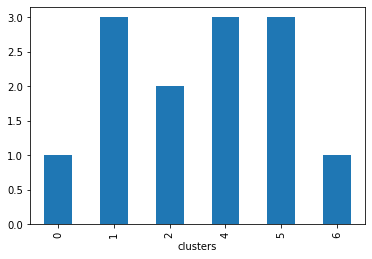

In [156]:
p['Golden State Warriors'].plot(kind='bar')

<AxesSubplot:xlabel='clusters'>

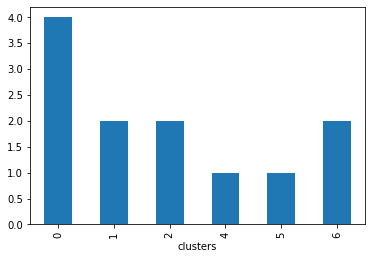

In [157]:
p['New York Knicks'].plot(kind='bar')

In [165]:
player_cluster_analysis['full_name'].unique()

array(['Atlanta Hawks', 'Boston Celtics', 'Cleveland Cavaliers',
       'New Orleans Pelicans', 'Chicago Bulls', 'Dallas Mavericks',
       'Denver Nuggets', 'Golden State Warriors', 'Houston Rockets',
       'Los Angeles Clippers', 'Los Angeles Lakers', 'Miami Heat',
       'Milwaukee Bucks', 'Minnesota Timberwolves', 'Brooklyn Nets',
       'New York Knicks', 'Orlando Magic', 'Indiana Pacers',
       'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers',
       'Sacramento Kings', 'San Antonio Spurs', 'Oklahoma City Thunder',
       'Toronto Raptors', 'Utah Jazz', 'Memphis Grizzlies',
       'Washington Wizards', 'Detroit Pistons', 'Charlotte Hornets'],
      dtype=object)

<AxesSubplot:xlabel='clusters'>

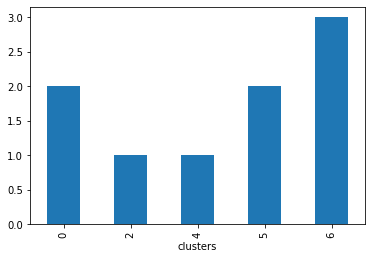

In [166]:
p['Utah Jazz'].plot(kind='bar')

In [214]:
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashptteamdefend, leaguedashptstats, BoxScoreAdvancedV2, leaguegamelog, teamestimatedmetrics

In [215]:
em = teamestimatedmetrics.TeamEstimatedMetrics(season='2020-21').get_data_frames()[0]

In [217]:
em.columns

Index(['TEAM_NAME', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'E_DEF_RATING', 'E_NET_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT',
       'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT', 'GP_RANK', 'W_RANK',
       'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'E_OFF_RATING_RANK',
       'E_DEF_RATING_RANK', 'E_NET_RATING_RANK', 'E_AST_RATIO_RANK',
       'E_OREB_PCT_RANK', 'E_DREB_PCT_RANK', 'E_REB_PCT_RANK',
       'E_TM_TOV_PCT_RANK', 'E_PACE_RANK'],
      dtype='object')

In [208]:
l = leaguegamelog.LeagueGameLog(season='2020-21').get_data_frames()[0]

In [211]:
l['GAME_ID'].drop_duplicates()

0       0022000001
2       0022000002
4       0022000003
6       0022000013
8       0022000017
           ...    
2150    0022001071
2152    0022001080
2154    0022001079
2156    0022001074
2158    0022001072
Name: GAME_ID, Length: 1080, dtype: object

In [212]:
b = BoxScoreAdvancedV2('0022000001').get_data_frames()[0]

In [213]:
b

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0022000001,1610612744,GSW,Golden State,203952,Andrew Wiggins,Andrew,F,,31:14,...,17.4,0.313,0.366,0.259,0.262,111.88,109.11,90.93,72,-0.044
1,0022000001,1610612744,GSW,Golden State,1629672,Eric Paschall,Eric,F,,21:33,...,0.0,0.417,0.436,0.127,0.130,112.22,111.37,92.81,49,0.012
2,0022000001,1610612744,GSW,Golden State,1630164,James Wiseman,James,C,,24:17,...,5.6,0.577,0.575,0.286,0.290,116.62,114.65,95.54,58,0.166
3,0022000001,1610612744,GSW,Golden State,1626162,Kelly Oubre Jr.,Kelly,G,,25:39,...,15.8,0.214,0.214,0.243,0.244,120.78,118.83,99.03,63,0.000
4,0022000001,1610612744,GSW,Golden State,201939,Stephen Curry,Stephen,G,,30:19,...,8.3,0.381,0.439,0.313,0.314,119.41,117.16,97.64,74,0.127
5,0022000001,1610612744,GSW,Golden State,1626172,Kevon Looney,Kevon,,,11:17,...,33.3,0.500,0.450,0.194,0.192,114.01,116.99,97.49,27,-0.036
6,0022000001,1610612744,GSW,Golden State,203145,Kent Bazemore,Kent,,,11:35,...,33.3,0.500,0.500,0.121,0.120,119.34,120.17,100.14,29,0.020
7,0022000001,1610612744,GSW,Golden State,1627814,Damion Lee,Damion,,,12:14,...,0.0,0.750,0.750,0.057,0.058,110.41,111.83,93.19,29,0.216
8,0022000001,1610612744,GSW,Golden State,1627737,Marquese Chriss,Marquese,,,12:26,...,0.0,0.450,0.450,0.294,0.296,107.32,104.24,86.86,27,0.205
9,0022000001,1610612744,GSW,Golden State,1629673,Jordan Poole,Jordan,,,17:55,...,22.2,0.250,0.250,0.133,0.135,103.63,103.14,85.95,38,0.000


In [203]:
defence = leaguedashptstats.LeagueDashPtStats(season='2020-21').get_data_frames()[0]

In [205]:
defence

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GP,W,L,MIN,DIST_FEET,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF
0,1610612737,ATL,Atlanta Hawks,72,41,31,17405.0,6750259,1278.5,695.3,583.1,4.14,4.44,3.83
1,1610612738,BOS,Boston Celtics,72,36,36,17380.0,6749562,1278.3,687.2,591.2,4.13,4.44,3.82
2,1610612751,BKN,Brooklyn Nets,72,48,24,17405.0,6632395,1256.1,674.6,581.5,4.08,4.48,3.69
3,1610612766,CHA,Charlotte Hornets,72,33,39,17355.0,7008041,1327.3,715.6,611.6,4.31,4.70,3.93
4,1610612741,CHI,Chicago Bulls,72,31,41,17380.0,6948337,1316.0,713.2,602.8,4.27,4.60,3.94
5,1610612739,CLE,Cleveland Cavaliers,72,22,50,17430.0,6780450,1284.2,698.9,585.3,4.16,4.42,3.89
6,1610612742,DAL,Dallas Mavericks,72,42,30,17305.0,6657137,1260.8,687.8,573.0,4.15,4.43,3.86
7,1610612743,DEN,Denver Nuggets,72,47,25,17480.0,6733133,1275.2,690.3,584.9,4.14,4.40,3.87
8,1610612765,DET,Detroit Pistons,72,20,52,17430.0,6870821,1301.3,714.7,586.6,4.24,4.54,3.93
9,1610612744,GSW,Golden State Warriors,72,39,33,17305.0,6847575,1296.9,686.0,610.8,4.26,4.67,3.87


In [193]:
td = leaguedashptteamdefend.LeagueDashPtTeamDefend(season='2020-21').get_data_frames()[0]

In [194]:
td

,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,GP,G,FREQ,D_FGM,D_FGA,D_FG_PCT,NORMAL_FG_PCT,PCT_PLUSMINUS
0,1610612752,New York Knicks,NYK,72,72,1.0,2715,6165,0.440,0.465,-0.024
1,1610612762,Utah Jazz,UTA,72,72,1.0,2939,6570,0.447,0.467,-0.020
2,1610612744,Golden State Warriors,GSW,72,72,1.0,2876,6363,0.452,0.464,-0.012
3,1610612755,Philadelphia 76ers,PHI,72,72,1.0,2835,6258,0.453,0.462,-0.009
4,1610612749,Milwaukee Bucks,MIL,72,72,1.0,3052,6689,0.456,0.464,-0.008
5,1610612747,Los Angeles Lakers,LAL,71,71,1.0,2822,6132,0.460,0.467,-0.007
6,1610612751,Brooklyn Nets,BKN,72,72,1.0,3016,6569,0.459,0.465,-0.006
7,1610612761,Toronto Raptors,TOR,72,72,1.0,2809,6097,0.461,0.464,-0.004
8,1610612742,Dallas Mavericks,DAL,72,72,1.0,2884,6265,0.460,0.463,-0.003
9,1610612746,LA Clippers,LAC,72,72,1.0,2864,6181,0.463,0.467,-0.003


In [184]:
t = leaguedashteamstats.LeagueDashTeamStats(season='2020-21', per_mode_detailed='Per100Possessions').get_data_frames()

In [185]:
t[0].columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK',
       'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
       'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK',
       'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK',
       'CFID', 'CFPARAMS'],
      dtype='object')

In [187]:
t = t[0]

In [188]:
t.PTS

0     114.3
1     113.1
2     117.3
3     110.1
4     110.4
5     105.2
6     114.6
7     116.3
8     107.6
9     110.5
10    107.0
11    111.9
12    116.7
13    109.8
14    111.7
15    110.6
16    116.5
17    109.3
18    113.0
19    110.2
20    102.8
21    104.6
22    112.5
23    116.3
24    117.1
25    112.7
26    110.5
27    111.6
28    116.5
29    110.7
Name: PTS, dtype: float64

In [169]:
player_cluster_analysis

,PLAYER_ID,PLAYER_NAME,full_name,POSITION,clusters
0,1629164,Brandon Goodwin,Atlanta Hawks,G,3
223,1628989,Kevin Huerter,Atlanta Hawks,G-F,6
954,101150,Lou Williams,Atlanta Hawks,G,1
1170,201568,Danilo Gallinari,Atlanta Hawks,F,1
1645,1629027,Trae Young,Atlanta Hawks,G,6
...,...,...,...,...,...
168074,1628997,Caleb Martin,Charlotte Hornets,F,2
168330,1628998,Cody Martin,Charlotte Hornets,F,4
168518,202330,Gordon Hayward,Charlotte Hornets,F,1
169176,1629023,P.J. Washington,Charlotte Hornets,F,4


In [170]:
t = teamyearbyyearstats.TeamYearByYearStats(team_id='1610612737').get_data_frames()

In [173]:
t[0].columns

Index(['TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'YEAR', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS', 'PTS_RANK'],
      dtype='object')

In [175]:
b = boxscoreadvancedv2.BoxScoreAdvancedV2()

TypeError: __init__() missing 1 required positional argument: 'game_id'